In [1]:
def resample_stock_data(df, timedelta):
    # make a copy
        df = df.copy()

        # convert index to datetime
        df.index = pd.to_datetime(df.index)

        # sort the index (evidently required by resample())
        df = df.sort_index()

        aggregation_dict = {
             'open': 'first', 
             'high': 'max',
             'low': 'min',
             'close': 'last',

        }

        rename_dict = {
            'open': 'open',
            'high': 'high',
            'low': 'low',
            'close': 'close',

        }


        return (df
          .resample(timedelta)
          .agg(aggregation_dict)
          .rename(columns=rename_dict)
        )

In [4]:
from numba import jit, cuda 

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")


class fifBacktester():
    ''' Class for the vectorized backtesting of 15 minutes high-based trading strategies.
    Attributes
    ==========
    
    r1: float
        returns more than prev day close
    r2: float
        returns more than fifteen minutes high
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets parameters
        
    test_strategy:
        runs the backtest for the strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two parameters
    '''
    
    def __init__(self, r1, r2, start, end):
        
        self.r1 = r1
        self.r2 = r2
        self.start = start
        self.end = end
        self.results = None 
        self.get_data()
#         self.set_targ_stoploss()
#         self.set_calls(r1,r2)
        
    def __repr__(self):
        return "SMABacktester( return1 = {}, return2 = {}, start = {}, end = {})".format( self.r1, self.r2, self.start, self.end)
    
    
           
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('bankniftyoneminutefinal.csv')
        raw['date_time']=pd.to_datetime(raw['date'] + ' ' + raw['time'])
        #raw=X.loc[:,'close']
        raw=raw.drop('Unnamed: 6', axis=1)
        raw=raw.set_index('date_time')
        raw = raw.loc[self.start:self.end]
        y=raw
        X_15=resample_stock_data(y,'15min')
        X_15=X_15.dropna()
        X_d=resample_stock_data(y,'1d')
        X_d=X_d.dropna()
        
        X_n=y.drop(['time'],axis=1)
        X_n['close_prev_day']=np.NaN
        ix=X_d.index
        
        my_df  = pd.DataFrame() 
        for i in range(len(X_d)):
            x=X_n.loc[str(ix[i].date())].fillna(X_d["close"][i])
            my_df=pd.concat([my_df,x])
            
        my_df['fif_min_high']=np.NaN
        my_df['fif_min_open']=np.NaN
        my_df['fif_min_close']=np.NaN
        my_df['fif_min_low']=np.NaN
        
        data3=pd.DataFrame() 
        for i in range(len(X_d)):
            dics={'fif_min_high':X_15.loc[str(ix[i].date())]['high'].iloc[0],
                  'fif_min_open':X_15.loc[str(ix[i].date())]['open'].iloc[0],
                   'fif_min_close':X_15.loc[str(ix[i].date())]['close'].iloc[0],
                  'fif_min_low':X_15.loc[str(ix[i].date())]['low'].iloc[0]
                    }
            s=my_df.loc[str(ix[i].date())].fillna(dics)
            data3=pd.concat([data3,s])
            
        
        
        data=data3
        data['close_prev_day']=data['close_prev_day'].shift(375)
        data=data.dropna()
        
        data=data.reset_index()
        data['time']=data['date_time'].dt.time
        data=data.set_index('time')
        ix2=data.index
        rem_list=ix2[0:15]
        data=data.drop(rem_list)
        data=data.set_index('date_time', drop=False)
        data['hour']=data['date_time'].dt.hour
        data['min']=data['date_time'].dt.minute
        data['returns']=data['open'].pct_change()
        data=data.dropna()
        self.data=data
    
         
    def set_targ_stoploss(self):
        data2=self.data
        targ_l=[]
        stp_l=[]
        targ_s=[]
        stp_s=[]
        for i in range(len(data2)):
            targ_l.append(2*abs(data2['fif_min_close'][i]-data2['fif_min_open'][i])+data2['fif_min_close'][i])
            stp_l.append(data2['fif_min_close'][i]-abs(data2['fif_min_close'][i]-data2['fif_min_open'][i]))
            targ_s.append(data2['fif_min_close'][i]-2*abs(data2['fif_min_close'][i]-data2['fif_min_open'][i]))
            stp_s.append(data2['fif_min_close'][i]+abs(data2['fif_min_close'][i]-data2['fif_min_open'][i]))
            
        data2['target_long']=targ_l
        data2['stoploss_long']=stp_l
        data2['target_short']=targ_s
        data2['stoploss_short']=stp_s
        
        return data2
    
    
    def set_calls(self, r1,r2):
        ''' Updates SMA parameters and resp. time series.
        '''
        data2=self.set_targ_stoploss()
        position=[]
        p=0
        for i in range(1,len(data2)):
            # giving buy call
            if(data2['fif_min_open'][i]>(1+r1)*data2['close_prev_day'][i] and data2['close'][i]>(1+r2)*data2['fif_min_high'][i] and p==0):
                position.append('buy')
                p=1
            elif(data2['close'][i]>data2['target_long'][i] and p==1):
                position.append('exit')
                p=2
            elif(data2['close'][i]<data2['stoploss_long'][i] and p==1):
                position.append('exit')
                p=2

            # giving sell call    
            elif(data2['fif_min_open'][i]<(1-r1)*data2['close_prev_day'][i] and data2['open'][i]<(1-r2)*data2['fif_min_low'][i] and p==0):
                position.append('sell')
                p=-1
            elif(data2['open'][i]<data2['target_short'][i] and p==-1):
                position.append('exit')
                p=2
            elif(data2['open'][i]>data2['stoploss_short'][i] and p==-1):
                position.append('exit')
                p=2


            elif(data2['hour'][i]>=15 and data2["min"][i]>=15 and (p==1 or p==-1)):
                position.append('exit')
                p=2
            elif(p==2 or p==0):
                position.append('No trade')
            elif(p==1):
                position.append('Buy_Hold')
            elif(p==-1):
                position.append('Sell_Hold')

            if(data2['date'][i-1]!=data2['date'][i]):
                p=0
        position.insert(0,'No trade')
        data2['call']=position
        self.fdata=data2
        return data2
        
         
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data2=self.set_calls(self.r1,self.r2)
        position=[]
        for i in range(len(data2)):

            if(data2['call'][i]=='buy' or data2['call'][i]=='Buy_Hold'):
                position.append(1)
            elif(data2['call'][i]=='sell' or data2['call'][i]=='Sell_Hold'):
                position.append(-1)
            else:
                position.append(0)
        data2['position']=position
        data2["strategy"] = data2["position"].shift(1) * data2["returns"]
        data2.dropna(inplace=True)
        data2["creturns"] = (1+data2["returns"]).cumprod()-1
        data2["cstrategy"] = (1+data2["strategy"]).cumprod()-1
        self.results = data2
        # absolute performance of the strategy
        perf = data2["cstrategy"].iloc[-1]
        
        return round(perf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = " strategy = {} | returns".format( self.r1)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
    
    
    def update_and_run(self, returns):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimazation algorithm).
        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_calls(int(returns[0]), int(returns[1]))
        return -self.test_strategy()
    
    
    def optimize_parameters(self, return_range1, return_range2):
        ''' Finds global maximum given the SMA parameter ranges.
        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (return_range1, return_range2), finish=None)
        return opt, -self.update_and_run(opt)

C:\Users\Harneet Singh\anaconda3\lib\site-packages\numba\core\decorators.py:150: NumbaDeprecationWarning: The 'target' keyword argument is deprecated.
  warnings.warn("The 'target' keyword argument is deprecated.", NumbaDeprecationWarning)


TypeError: __init__() got an unexpected keyword argument 'py_func'

In [3]:
tester = fifBacktester( 0,0, "2015-01-14", "2020-11-27")

In [4]:
tester.data.isnull().sum()

date_time         0
date              0
open              0
high              0
low               0
close             0
close_prev_day    0
fif_min_high      0
fif_min_open      0
fif_min_close     0
fif_min_low       0
hour              0
min               0
returns           0
dtype: int64

In [175]:
tester.data.tail(5)

,date_time,date,open,high,low,close,close_prev_day,fif_min_high,fif_min_open,fif_min_close,fif_min_low,hour,min,returns
date_time,,,,,,,,,,,,,,
2020-11-27 15:25:00,2020-11-27 15:25:00,11/27/2020,29632.60,29634.75,29618.35,29618.35,29603.2,29692.65,29622.0,29531.75,29469.6,15,25,0.000187
2020-11-27 15:26:00,2020-11-27 15:26:00,11/27/2020,29612.30,29613.15,29580.90,29588.75,29603.2,29692.65,29622.0,29531.75,29469.6,15,26,-0.000685
2020-11-27 15:27:00,2020-11-27 15:27:00,11/27/2020,29587.75,29591.05,29569.60,29569.60,29603.2,29692.65,29622.0,29531.75,29469.6,15,27,-0.000829
2020-11-27 15:28:00,2020-11-27 15:28:00,11/27/2020,29577.10,29629.05,29570.35,29597.25,29603.2,29692.65,29622.0,29531.75,29469.6,15,28,-0.000360
2020-11-27 15:29:00,2020-11-27 15:29:00,11/27/2020,29595.90,29631.45,29563.80,29584.55,29603.2,29692.65,29622.0,29531.75,29469.6,15,29,0.000636


In [150]:
df=tester.targ_data

AttributeError: 'fifBacktester' object has no attribute 'targ_data'

In [143]:
df[df['call']=='buy']

,date_time,date,open,high,low,close,close_prev_day,fif_min_high,fif_min_open,fif_min_close,...,returns,target_long,stoploss_long,target_short,stoploss_short,call,position,strategy,creturns,cstrategy
date_time,,,,,,,,,,,,,,,,,,,,,
2015-01-19 09:57:00,2015-01-19 09:57:00,1/19/2015,19396.20,19405.20,19388.95,19405.20,19134.65,19401.40,19384.20,19400.60,...,0.000588,19695.20,19253.30,19106.00,19547.90,buy,1,0.0,0.006403,0.000000
2015-01-20 09:34:00,2015-01-20 09:34:00,1/20/2015,19489.60,19505.45,19489.60,19505.45,19401.45,19503.95,19446.80,19491.50,...,-0.000121,19786.10,19344.20,19196.90,19638.80,buy,1,-0.0,0.011249,0.000822
2015-01-21 09:33:00,2015-01-21 09:33:00,1/21/2015,19916.95,19931.85,19916.95,19923.00,19761.10,19924.25,19811.85,19908.90,...,0.000834,20203.50,19761.60,19614.30,20056.20,buy,1,0.0,0.033423,0.015612
2015-01-22 10:33:00,2015-01-22 10:33:00,1/22/2015,19894.70,19906.20,19893.00,19902.85,19819.90,19898.50,19898.50,19820.65,...,-0.000123,20115.25,19673.35,19526.05,19967.95,buy,1,-0.0,0.032268,0.012287
2015-01-23 09:34:00,2015-01-23 09:34:00,1/23/2015,20154.80,20161.60,20153.50,20161.60,19931.65,20158.00,20133.85,20135.40,...,0.000097,20430.00,19988.10,19840.80,20282.70,buy,1,0.0,0.045764,0.012373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-17 09:42:00,2020-11-17 09:42:00,11/17/2020,28923.80,28967.25,28918.65,28957.60,28466.00,28939.95,28792.25,28938.20,...,0.000574,29232.80,28790.90,28643.60,29085.50,buy,1,0.0,0.500758,3.774025
2020-11-20 13:49:00,2020-11-20 13:49:00,11/20/2020,29101.95,29171.35,29101.60,29171.35,28837.65,29126.50,28935.75,28861.80,...,-0.000500,29156.40,28714.50,28567.20,29009.10,buy,1,-0.0,0.510001,3.787620
2020-11-24 09:34:00,2020-11-24 09:34:00,11/24/2020,29424.40,29431.40,29414.70,29429.05,29031.45,29425.00,29265.60,29415.45,...,0.000466,29710.05,29268.15,29120.85,29562.75,buy,1,0.0,0.526732,3.799226


In [121]:
tester.set_calls(0,0)

In [5]:
tester.test_strategy()

0.012101

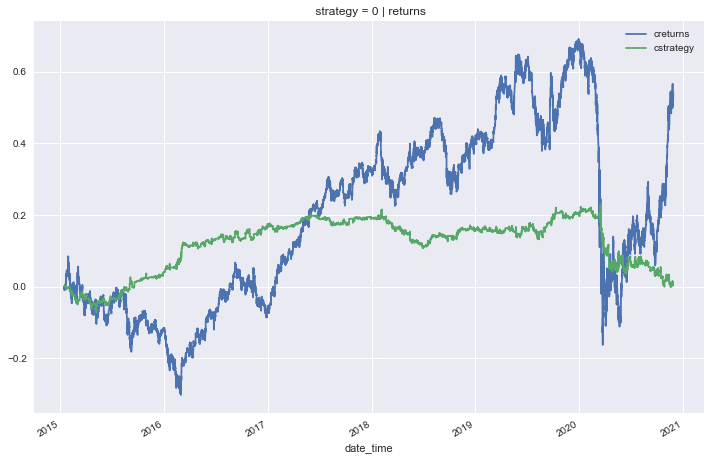

In [6]:
tester.plot_results()

In [7]:
tester.optimize_parameters( (0,0.01,0.001),(0,0.00001,0.00001))

(array([0., 0.]), 0.012101)

In [ ]:
tester

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")


class fifBacktester():
    ''' Class for the vectorized backtesting of SMA-based trading strategies.
    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, r1, start, end):
        
        self.r1 = r1
        self.start = start
        self.end = end
        self.results = None 
        self.get_data()
#         self.set_targ_stoploss()
#         self.set_calls(r1,r2)
        
    def __repr__(self):
        return "SMABacktester( return1 = {}, start = {}, end = {})".format( self.r1, self.start, self.end)
    
    
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('bankniftyoneminutefinal.csv')
        raw['date_time']=pd.to_datetime(raw['date'] + ' ' + raw['time'])
        #raw=X.loc[:,'close']
        raw=raw.drop('Unnamed: 6', axis=1)
        raw=raw.set_index('date_time')
        raw = raw.loc[self.start:self.end]
        y=raw
        X_15=resample_stock_data(y,'15min')
        X_15=X_15.dropna()
        X_d=resample_stock_data(y,'1d')
        X_d=X_d.dropna()
        
        X_n=y.drop(['time'],axis=1)
        X_n['close_prev_day']=np.NaN
        ix=X_d.index
        
        my_df  = pd.DataFrame() 
        for i in range(len(X_d)):
            x=X_n.loc[str(ix[i].date())].fillna(X_d["close"][i])
            my_df=pd.concat([my_df,x])
            
        my_df['fif_min_high']=np.NaN
        my_df['fif_min_open']=np.NaN
        my_df['fif_min_close']=np.NaN
        my_df['fif_min_low']=np.NaN
        
        data3=pd.DataFrame() 
        for i in range(len(X_d)):
            dics={'fif_min_high':X_15.loc[str(ix[i].date())]['high'].iloc[0],
                  'fif_min_open':X_15.loc[str(ix[i].date())]['open'].iloc[0],
                   'fif_min_close':X_15.loc[str(ix[i].date())]['close'].iloc[0],
                  'fif_min_low':X_15.loc[str(ix[i].date())]['low'].iloc[0]
                    }
            s=my_df.loc[str(ix[i].date())].fillna(dics)
            data3=pd.concat([data3,s])
            
        
        
        data=data3
        data['close_prev_day']=data['close_prev_day'].shift(375)
        data=data.dropna()
        
        data=data.reset_index()
        data['time']=data['date_time'].dt.time
        data=data.set_index('time')
        ix2=data.index
        rem_list=ix2[0:15]
        data=data.drop(rem_list)
        data=data.set_index('date_time', drop=False)
        data['hour']=data['date_time'].dt.hour
        data['min']=data['date_time'].dt.minute
        data['returns']=data['open'].pct_change()
        data=data.dropna()
        self.data=data
        
    def set_targ_stoploss(self):
        data2=self.data
        data2['target_long']=2*abs(data2['fif_min_close'][0]-data2['fif_min_open'][0])+data2['fif_min_close']
        data2['stoploss_long']=data2['fif_min_close']-abs(data2['fif_min_close'][0]-data2['fif_min_open'][0])
        data2['target_short']=data2['fif_min_close']-2*abs(data2['fif_min_close'][0]-data2['fif_min_open'][0])
        data2['stoploss_short']=data2['fif_min_close']+abs(data2['fif_min_close'][0]-data2['fif_min_open'][0])
        self.targ_data=data2
        return data2
    
    def set_calls(self, r1):
        ''' Updates SMA parameters and resp. time series.
        '''
        data2=self.set_targ_stoploss()
        position=[]
        p=0
        for i in range(1,len(data2)):
            # giving buy call
            if(data2['fif_min_open'][i]>(1+r1)*data2['close_prev_day'][i] and data2['open'][i]>data2['fif_min_high'][i] and p==0):
                position.append('buy')
                p=1
            elif(data2['open'][i]>data2['target_long'][i] and p==1):
                position.append('exit')
                p=2
            elif(data2['open'][i]<data2['stoploss_long'][i] and p==1):
                position.append('exit')
                p=2

            # giving sell call    
            elif(data2['fif_min_open'][i]<(1-r1)*data2['close_prev_day'][i] and data2['open'][i]<data2['fif_min_low'][i] and p==0):
                position.append('sell')
                p=-1
            elif(data2['open'][i]<data2['target_short'][i] and p==-1):
                position.append('exit')
                p=2
            elif(data2['open'][i]>data2['stoploss_short'][i] and p==-1):
                position.append('exit')
                p=2


            elif(data2['hour'][i]>=15 and data2["min"][i]>=15 and (p==1 or p==-1)):
                position.append('exit')
                p=2
            elif(p==2 or p==0):
                position.append('No trade')
            elif(p==1):
                position.append('Buy_Hold')
            elif(p==-1):
                position.append('Sell_Hold')

            if(data2['date'][i-1]!=data2['date'][i]):
                p=0
        position.insert(0,'No trade')
        data2['call']=position
        self.fdata=data2
        return data2
        
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data2=self.set_calls(self.r1)
        position=[]
        for i in range(len(data2)):

            if(data2['call'][i]=='buy' or data2['call'][i]=='Buy_Hold'):
                position.append(1)
            elif(data2['call'][i]=='sell' or data2['call'][i]=='Sell_Hold'):
                position.append(-1)
            else:
                position.append(0)
        data2['position']=position
        data2["strategy"] = data2["position"].shift(1) * data2["returns"]
        data2.dropna(inplace=True)
        data2["creturns"] = (1+data2["returns"]).cumprod()-1
        data2["cstrategy"] = (1+data2["strategy"]).cumprod()-1
        self.results = data2
        # absolute performance of the strategy
        perf = data2["cstrategy"].iloc[-1]
        
        return round(perf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = " strategy = {} | returns".format( self.r1)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self,r):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimazation algorithm).
        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_calls(r)
        return -self.test_strategy()
    
    def optimize_parameters(self, return_range1):
        ''' Finds global maximum given the SMA parameter ranges.
        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, return_range1, finish=None)
        return opt, -self.update_and_run(opt)